# Access CESM LENS data from NCAR's Research Data Archive and compute GMST

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
# import s3fs
import seaborn as sns
import nc_time_axis

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
catalog_url = 'https://data.rda.ucar.edu/harshah/intake_catalogs/osdf/cesm2-lens-aws-osdf/aws-cesm2-le.json'

In [4]:
# GMST function ###
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time','member_id'}
    return (ds * weight).mean(other_dims)

In [5]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [6]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/39657/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/39657/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.93:44263,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/39657/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
cluster.scale(12)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/39657/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.93:44263,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/39657/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
# Open collection description file using intake
col         = intake.open_esm_datastore(catalog_url)
col

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [9]:
cesm_temp = col.search(variable ='TREFHT', frequency ='monthly')
cesm_temp

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [10]:
cesm_temp.df['path'].values

array(['osdf:///ncar/rda/d010092/atm/monthly/cesm2LE-historical-cmip6-TREFHT.zarr',
       'osdf:///ncar/rda/d010092/atm/monthly/cesm2LE-historical-smbb-TREFHT.zarr',
       'osdf:///ncar/rda/d010092/atm/monthly/cesm2LE-ssp370-cmip6-TREFHT.zarr',
       'osdf:///ncar/rda/d010092/atm/monthly/cesm2LE-ssp370-smbb-TREFHT.zarr'],
      dtype=object)

In [11]:
dsets_cesm = cesm_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [12]:
dsets_cesm.keys()

dict_keys(['atm.historical.monthly.smbb', 'atm.ssp370.monthly.cmip6', 'atm.ssp370.monthly.smbb', 'atm.historical.monthly.cmip6'])

In [13]:
historical_cmip6 = dsets_cesm['atm.historical.monthly.cmip6']
future_cmip6     = dsets_cesm['atm.ssp370.monthly.cmip6']

In [14]:
future_cmip6 

<xarray.Dataset> Size: 11GB
Dimensions:    (member_id: 50, time: 1032, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHT     (member_id, time, lat, lon) float32 11GB dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                       CF-1.0
    host:                              mom1
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  month_1
    ...                                ...
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       2015-01-16 12:00:00
    intake_esm_attrs:end_time:         2100-12-16 12:00:00
    intake_esm_attrs:path:             osdf:///ncar/rda/d010092/atm/monthly/c...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.ssp370.monthly.cmip6

In [15]:
merge_ds_cmip6 = xr.concat([historical_cmip6, future_cmip6], dim='time')
# merge_ds_cmip6 = merge_ds_cmip6.dropna(dim='member_id')
merge_ds_cmip6 = merge_ds_cmip6.TREFHT
merge_ds_cmip6

<xarray.DataArray 'TREFHT' (member_id: 50, time: 3012, lat: 192, lon: 288)> Size: 33GB
dask.array<concatenate, shape=(50, 3012, 192, 288), dtype=float32, chunksize=(1, 600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

### Calculate GMST 

#### Compute (spatially weighted) Global Mean

In [16]:
ds_cmip6_annual = merge_ds_cmip6.resample(time='AS').mean()
ds_cmip6_annual

<xarray.DataArray 'TREFHT' (member_id: 50, time: 251, lat: 192, lon: 288)> Size: 3GB
dask.array<transpose, shape=(50, 251, 192, 288), dtype=float32, chunksize=(1, 1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [17]:
%%time
gmst_cmip6 = global_mean(ds_cmip6_annual)
gmst_cmip6 = gmst_cmip6.rename('gmst')
gmst_cmip6

CPU times: user 86.2 ms, sys: 7.49 ms, total: 93.7 ms
Wall time: 102 ms


<xarray.DataArray 'gmst' (member_id: 50, time: 251)> Size: 100kB
dask.array<mean_agg-aggregate, shape=(50, 251), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00

### Turn the result into a data frame and plot

In [18]:
# %%time
# gmst_cmip6_df = gmst_cmip6.to_dataframe().reset_index()
# gmst_cmip6_df.head()

In [19]:
# %%time
# sns.relplot(data=gmst_cmip6_df, x="time", y="gmst", hue='member_id',kind="line", ci="sd", aspect=2)

### Compute anomaly and plot

In [20]:
gmst_cmip6_ano = gmst_cmip6 - gmst_cmip6.mean()
gmst_cmip6_ano

<xarray.DataArray 'gmst' (member_id: 50, time: 251)> Size: 100kB
dask.array<sub, shape=(50, 251), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00

In [21]:
gmst_cmip6_ano = gmst_cmip6_ano.compute()

CPU times: user 43.6 ms, sys: 3.73 ms, total: 47.3 ms
Wall time: 64 ms


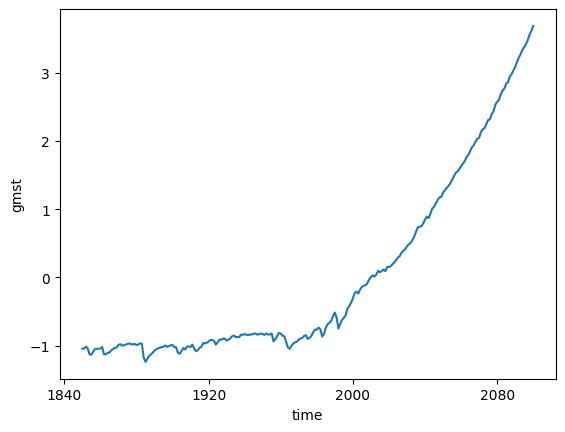

In [22]:
%%time
gmst_cmip6_ano.mean(dim='member_id').plot()